In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from falsify_data import removemap
from utils import *

In [2]:
pos_rxn = pd.read_csv('cleaned_uspto50k.csv')
pos_rxn['label'] = 1
# preprocess to let true dataset look more like false dataset
# remove atom map
pos_rxn['rxn_smiles'] = [removemap(rxn) for rxn in tqdm(pos_rxn['rxn_smiles'])]
pos_rxn_can = []
# split reactants & products
for rxn in tqdm(pos_rxn['rxn_smiles']):
    rt, pt = rxn2rtpt(rxn)
    # canonicalize products SMILES
    pt = can_SMILES(pt)
    # canonicalize reaction SMILES format
    pos_rxn_can.append('>>'.join((rt, pt)))
pos_rxn['rxn_smiles'] = pos_rxn_can
pos_rxn = pos_rxn[['rxn_smiles', 'label']]
pos_rxn = pos_rxn.drop_duplicates(subset='rxn_smiles').reset_index(drop=True)
pos_rxn

100%|██████████| 42003/42003 [00:25<00:00, 1647.48it/s]


,rxn_smiles,label
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,1
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,1
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,1
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,1
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,1
...,...,...
41997,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,1
41998,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu]>>N...,1
41999,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO>...,1
42000,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...,1


In [3]:
neg_rxn_1 = pd.read_csv('negative_strict.csv')
neg_rxn_1 = neg_rxn_1[['rxn_smiles', 'label']]
neg_rxn_1 = neg_rxn_1.drop_duplicates(subset='rxn_smiles')
neg_rxn_2 = pd.read_csv('negative_random_comprehensive.csv')
neg_rxn_2 = neg_rxn_2.drop_duplicates(subset='rxn_smiles').reset_index(drop=True)
neg_rxn_2 = neg_rxn_2[['rxn_smiles', 'label']]
# random sub-sample neg_rxn_2 to have a equally labeled dataset
neg_rxn_2 = neg_rxn_2.loc[np.random.choice(a=len(neg_rxn_2), size=42000, replace=False)]
neg_rxn_2 = neg_rxn_2.drop_duplicates(subset='rxn_smiles')
neg_rxn = pd.concat([neg_rxn_1, neg_rxn_2]).drop_duplicates(subset='rxn_smiles')
neg_rxn

,rxn_smiles,label
0,BrCc1ccccc1.Oc1ccc(O)c(Br)c1>>Oc1ccc(OCc2ccccc...,0
1,CC(C)(C)OC(=O)NCC1CCNCC1.O=S(=O)(Cl)c1cccc2cnc...,0
2,CCSc1nc(Cl)cc(C)c1C(=O)NCc1cccc(F)c1.OC[C@H]1C...,0
3,NCC1(O)CCCC1.O=[N+]([O-])c1cc(Br)ccc1Br>>O=[N+...,0
4,CCNCC1CCNC1.CCn1cc(C(=O)O)c(=O)c2cc(F)c(Cl)nc2...,0
...,...,...
177503,CC(=O)Cl.CCOCc1nc2c(N)nc3cc(OCCCCCCN)ccc3c2n1C...,0
335241,CC(C)(O)CC(=O)O.N[C@H]1CC[C@H](CCN2CCC(c3cccc4...,0
88606,CN(C)S(=O)(=O)c1ccccc1Nc1nc(Cl)ncc1Cl.Nc1ccc2c...,0
317426,Cc1nc2ccccc2[nH]1.Clc1nc(N2CCOCC2)c2sccc2n1>>C...,0


In [4]:
all_rxn = pd.concat([pos_rxn, neg_rxn])
# suffle rows & reset index
all_rxn = all_rxn.drop_duplicates(subset='rxn_smiles').sample(frac=1).reset_index(drop=True)
rt_list = []
for rxn in all_rxn['rxn_smiles']:
    rt, _ = rxn2rtpt(rxn)
    # sort reactants in a uniform order
    rt_list.append('.'.join(sorted(rt.split('.'))))
all_rxn['rt'] = rt_list
# generate Morgan Fingerprints
all_rxn['ECFP4'] = [list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=64)) for smi in tqdm(rt_list)]
all_rxn

100%|██████████| 85914/85914 [01:01<00:00, 1399.21it/s]


,rxn_smiles,label,rt,ECFP4
0,CC(C)N.C[C@@H](NC(=O)c1cn(COCC[Si](C)(C)C)c2nc...,1,CC(C)N.C[C@@H](NC(=O)c1cn(COCC[Si](C)(C)C)c2nc...,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, ..."
1,CCOc1ncnc2[nH]cc(Cc3ccc(Nc4ccc(Br)nc4)nc3F)c12...,0,CCOc1ncnc2[nH]cc(Cc3ccc(Nc4ccc(Br)nc4)nc3F)c12,"[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ..."
2,CCCC1(O)CCC(C2CCC(COc3ccc(OCC)c(F)c3F)CC2)CO1>...,0,CCCC1(O)CCC(C2CCC(COc3ccc(OCC)c(F)c3F)CC2)CO1,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, ..."
3,CC(=O)N1CCNCC1.O=Cc1ccnc(Cl)c1F>>CC(=O)N1CCN(C...,1,CC(=O)N1CCNCC1.O=Cc1ccnc(Cl)c1F,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
4,COc1cc2c(cc1Cl)N(C)CC(C(=O)O)O2.C[C@@H]1CN(Cc2...,0,COc1cc2c(cc1Cl)N(C)CC(C(=O)O)O2.C[C@@H]1CN(Cc2...,"[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, ..."
...,...,...,...,...
85909,CC(C)(C)c1ccc(Cn2cnc(N)c2C(N)=O)cc1.O=C(Cl)c1c...,1,CC(C)(C)c1ccc(Cn2cnc(N)c2C(N)=O)cc1.O=C(Cl)c1c...,"[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, ..."
85910,O=C(Nc1ccc2c(c1)c(-c1nc3cc(N4CCOCC4)ccc3[nH]1)...,1,O=C(Nc1ccc2c(c1)c(-c1nc3cc(N4CCOCC4)ccc3[nH]1)...,"[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, ..."
85911,CC(=O)c1nn(C)c(-c2ccc3c(c2)CCC3)c1O.NNC(=O)c1c...,0,CC(=O)c1nn(C)c(-c2ccc3c(c2)CCC3)c1O.NNC(=O)c1c...,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."
85912,CC(C)(C)OC(=O)N1CCCc2ccc(CCO)nc21.CCCC(CC(=O)O...,0,CC(C)(C)OC(=O)N1CCCc2ccc(CCO)nc21.CCCC(CC(=O)O...,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, ..."


### train, valid, test split

In [5]:
X = np.array(all_rxn['ECFP4'].values.tolist())

# the first PC grabs major variance
pca = PCA(n_components=2)
pca.fit(X.transpose())
X_pca = pca.components_.transpose()

c:\Users\yifen\anaconda3\envs\AIHacks\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

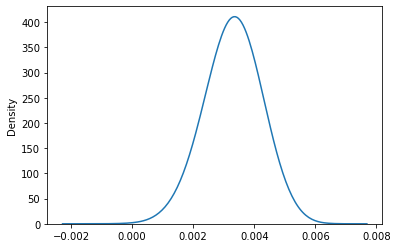

In [6]:
sns.kdeplot(X_pca[:,0], bw=0.5)

In [7]:
# train_size, valid_size and test_size should sum to 1.0!!!
train_size = 0.7
valid_size = 0.2
test_size = 0.1

In [8]:
# Two-tail double-side split
# calculate percentile from split size
train_prec = [
    [(1-train_size)*0.25, 0.25+train_size*0.25], 
    [0.5+(1-train_size)*0.25, 0.75+train_size*0.25]
]
valid_prec = [
    [test_size*0.25, (test_size+valid_size)*0.25], 
    [0.25+train_size*0.25, 0.25+(train_size+valid_size)*0.25], 
    [0.5+test_size*0.25, 0.5+(test_size+valid_size)*0.25], 
    [0.75+train_size*0.25, 0.75+(train_size+valid_size)*0.25]
]
test_prec = [
    [0.0, test_size*0.25],
    [0.25+(train_size+valid_size)*0.25, 0.5],
    [0.5, 0.5+test_size*0.25],
    [0.75+(train_size+valid_size)*0.25, 1.0]
]

In [9]:
train_split = [np.percentile(X_pca[:,0], np.array(itv)*100) for itv in train_prec]
valid_split = [np.percentile(X_pca[:,0], np.array(itv)*100) for itv in valid_prec]
test_split = [np.percentile(X_pca[:,0], np.array(itv)*100) for itv in test_prec]
test_split[0][0] -= 1
test_split[3][1] += 1

In [10]:
def getIDFromSplit(X, split):
    ids = []
    for itv in split:
        upBound = np.arange(len(X))[X <= itv[1]]
        loBound = np.arange(len(X))[X > itv[0]]
        ids += list(set(upBound).intersection(set(loBound)))
    return ids

train_id = getIDFromSplit(X_pca[:,0], train_split)
valid_id = getIDFromSplit(X_pca[:,0], valid_split)
test_id = getIDFromSplit(X_pca[:,0], test_split)

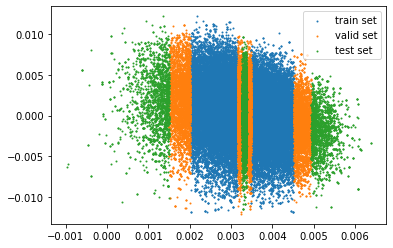

In [11]:
plt.scatter(X_pca[train_id,0], X_pca[train_id,1], s=1, label='train set')
plt.scatter(X_pca[valid_id,0], X_pca[valid_id,1], s=1, label='valid set')
plt.scatter(X_pca[test_id,0], X_pca[test_id,1], s=1, label='test set')
plt.legend()

In [12]:
len(train_id + test_id + valid_id)

85914